# 3. SAR-анализ

In [127]:
import pandas as pd

data_clean = pd.read_csv("data/clean_subset.csv")

ic50 = pd.read_csv("data/IC50.csv")

Чистим

In [128]:
import datamol as dm

def _preprocess(i, row):
    dm.disable_rdkit_log()
    mol = dm.to_mol(row["SMILES"], ordered=True, sanitize=False)
    if mol is None:
        smiles_main = row["SMILES"].split(".")[0]
        #print(f"Trying split for: {row['smiles']} -> {smiles_main}") 
        mol = dm.to_mol(smiles_main, ordered=True, sanitize=False)
        if mol is None:
            print(f"Error: {row['SMILES']}")
            row["standard_smiles"] = None
            return row

    mol = dm.remove_salts_solvents(mol)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
            
    mol = dm.standardize_mol(
        mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True
    )
    
    row["standard_smiles"] = dm.to_smiles(mol, canonical = True)
    
    return row

ic50_clean = dm.parallelized(_preprocess, ic50.iterrows(), arg_type="args", progress=True, total=len(ic50))
ic50_clean = [row for row in ic50_clean if row is not None]
ic50_clean = pd.DataFrame(ic50_clean)
ic50_clean

  0%|          | 0/665 [00:00<?, ?it/s]

,SMILES,IC50_nM,standard_smiles
0,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCNCC3)cc2)c...,2229.000,Cc1ccc(NC(=O)c2ccc(CN3CCNCC3)cc2)cc1Nc1nccc(-c...
1,COCCN(C)/N=N/c1ccc(C(=O)Nc2cccc(Nc3nccc(-c4ccc...,33189.450,COCCN(C)/N=N/c1ccc(C(=O)Nc2cccc(Nc3nccc(-c4ccc...
2,Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1,18.000,Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1
3,CCN(CC)c1ccc(NC(=O)Nc2ccc(C)c(Nc3nccc(-c4cccnc...,10000.000,CCN(CC)c1ccc(NC(=O)Nc2ccc(C)c(Nc3nccc(-c4cccnc...
4,Cc1ccc(NC(=O)Nc2cccc(N3CCCC3)c2)cc1Nc1nccc(-c2...,724.440,Cc1ccc(NC(=O)Nc2cccc(N3CCCC3)c2)cc1Nc1nccc(-c2...
...,...,...,...
660,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,0.016,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...
661,Cc1ncc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,21.700,Cc1ncc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
662,Cc1ncc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,17.400,Cc1ncc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
663,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,486.500,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...


Нормализация IC50

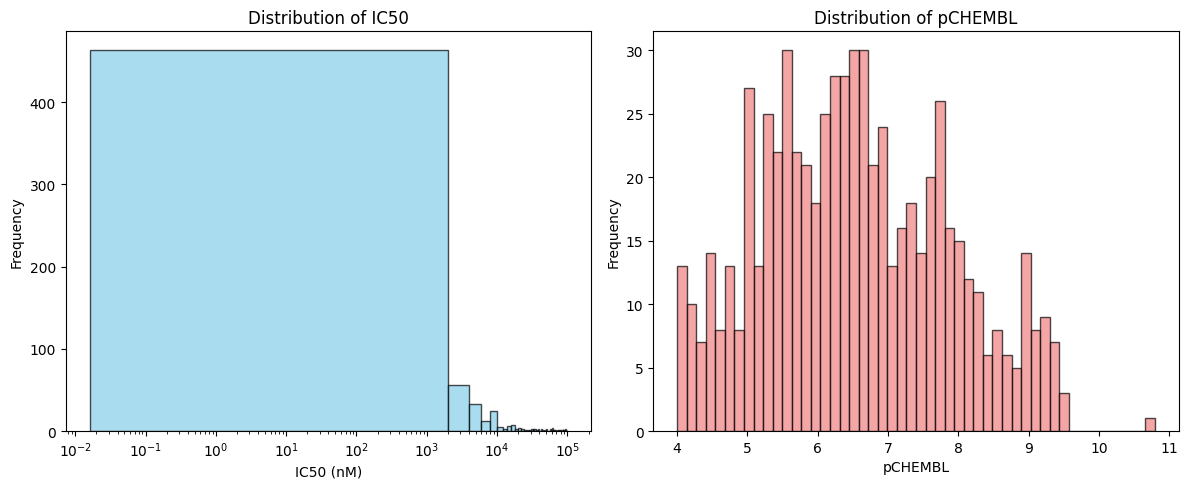

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Нормализация IC50
ic50_clean['pCHEMBL'] = -np.log10(ic50_clean['IC50_nM'] * 1e-9)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(ic50_clean['IC50_nM'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('IC50 (nM)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of IC50')
ax1.set_xscale('log')

ax2.hist(ic50_clean['pCHEMBL'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')

ax2.set_xlabel('pCHEMBL')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of pCHEMBL')

plt.tight_layout()
plt.show()


ic50_clean = ic50_clean.drop(columns=['SMILES','IC50_nM'])


Хорошие значения активности: pCHEMBL ≥ 7

Очень хорошие/редкие: pCHEMBL ≥ 8

Слабые/не рассматриваются: pCHEMBL < 6

Убираем дубликаты

In [ ]:
duplicates = ic50_clean["standard_smiles"].duplicated().sum()
print(f"Duplicates before: {duplicates}")

ic50_clean = ic50_clean.groupby("standard_smiles").agg({"pCHEMBL": "median"}).reset_index()
print(f"Unique compounds after: {len(ic50_clean)}")

ic50_clean.to_csv("data/ic50_clean.csv", index=False)

Duplicates before: 208
Unique compounds after: 457


Ну вдруг

In [131]:
ic50_smiles = set(ic50_clean["standard_smiles"])
data_smiles = set(data_clean["standard_smiles"])

intersection = ic50_smiles & data_smiles
unique_ic50 = ic50_smiles - data_smiles
unique_data = data_smiles - ic50_smiles

print(f"Intersections: {len(intersection)}")


Intersections: 0


Начинаем matched molecular pairs (MMP)

In [ ]:
import datamol as dm
import pandas as pd

mols = [dm.to_mol(smi, add_hs=False) for smi in ic50_clean['standard_smiles']]
activities = ic50_clean['pCHEMBL'].values

ic50_clean = ic50_clean.reset_index()
ic50_clean = ic50_clean.rename(columns={'index': 'id'})

props = ic50_clean[["id", "pCHEMBL"]]
props.columns = ["ID", "pCHEMBL"]
props.to_csv("data/mmp/props.tsv", sep="\t", index=False)

ic50_mmpdb = ic50_clean.drop(columns=['pCHEMBL'])
ic50_mmpdb = ic50_mmpdb[['standard_smiles', 'id']]
ic50_mmpdb.to_csv("data/mmp/actives.smi", sep=" ", header=False, index=False)

In [133]:
!mmpdb fragment data/mmp/actives.smi -o data/mmp/actives.fragdb

In [ ]:
!mmpdb index data/mmp/actives.fragdb -o data/mmp/actives.mmpdb

In [135]:
!mmpdb loadprops -p data/mmp/props.tsv data/mmp/actives.mmpdb

Using dataset: MMPs from 'data/mmp/actives.fragdb'
Reading properties from 'data/mmp/props.tsv'
Read 1 properties for 457 compounds from 'data/mmp/props.tsv'
24 compounds from 'data/mmp/props.tsv' are not in the dataset at 'data/mmp/actives.mmpdb'
Imported 433 'pCHEMBL' records (433 new, 0 updated).
Number of rule statistics added: 13406 updated: 0 deleted: 0
Loaded all properties and re-computed all rule statistics.


In [ ]:
!mmpdb list data/mmp/actives.mmpdb

         Name          #cmpds #rules #pairs #envs  #stats  |------------- Title -------------| Properties
data/mmp/actives.mmpdb    433   1888  18384  13406  13406  MMPs from 'data/mmp/actives.fragdb' pCHEMBL


In [156]:
!mmpdb proprulecat data/mmp/actives.mmpdb --min-count 3 -o data/mmp/all_rules.tsv

In [198]:
rules = pd.read_csv("data/mmp/all_rules.tsv", sep="\t")

top = (rules[(rules["radius"] == 0)   # только простейшие MMP
             & (rules["median"] > 0)  # активность повышается
             & (rules["count"] >= 3)]  # статистика не на шуме
          .sort_values("median", ascending=False).head(10))


top.to_csv("data/mmp/top_rules.csv", index=False)
print("Saved data/mmp/top_rules.csv")

Saved data/mmp/top_rules.csv


### Визуализировать примеры (например, “R-group analysis”)

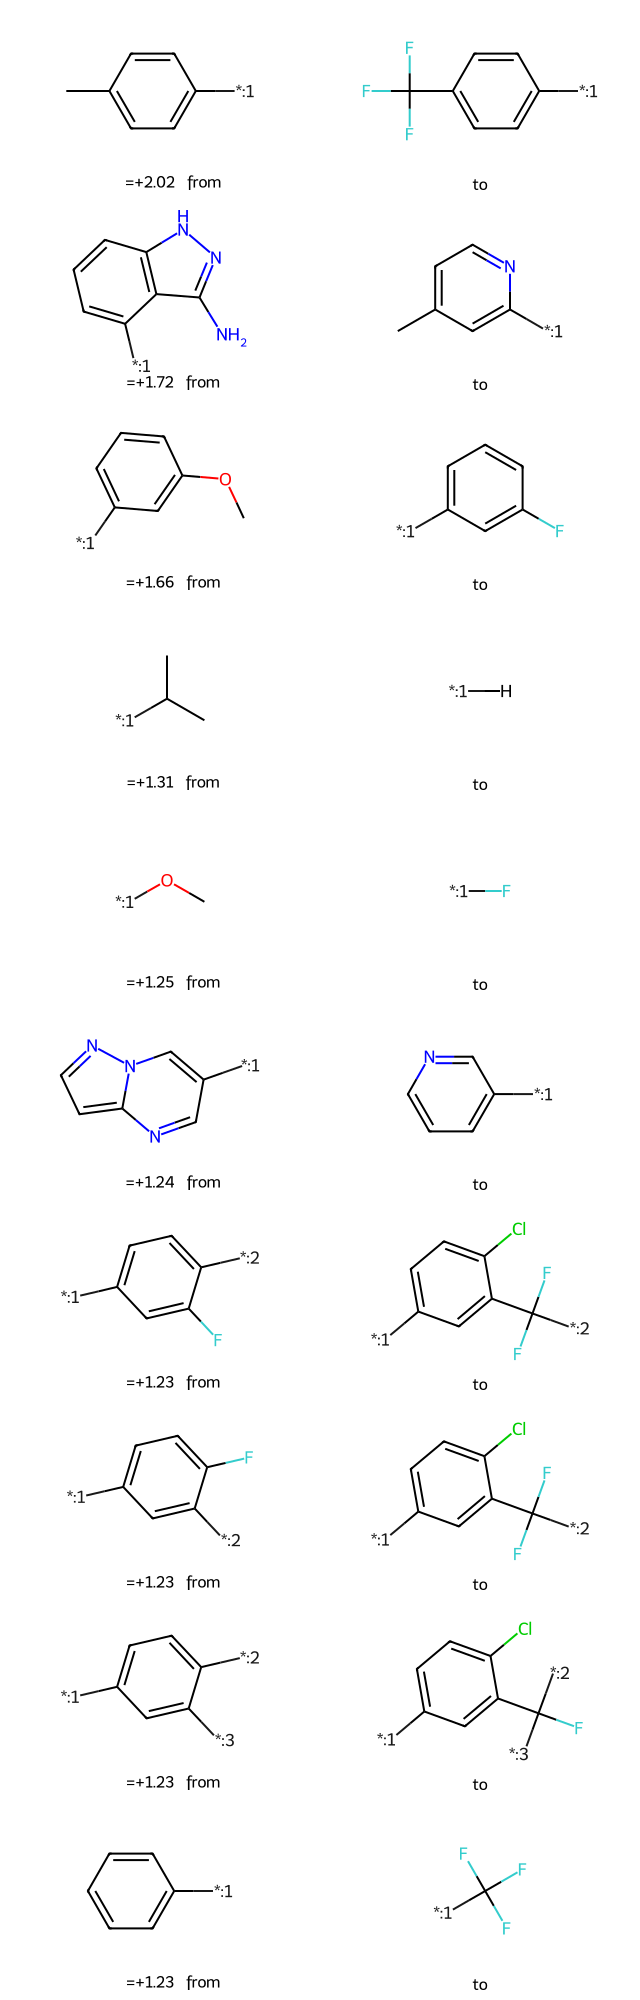

In [199]:
mols, legends = [], []
for _, r in top.iterrows():
    with dm.without_rdkit_log():
        mols += [dm.to_mol(r["from_smiles"]),
                dm.to_mol(r["to_smiles"])]
        legends += [f"Δ={r['median']:+.2f}  from",
                    "to"]

img = dm.to_image(mols,
                  legends=legends,
                  mol_size=(320, 200),
                  n_cols=2)

display(img)